In [73]:
from matplotlib import pyplot as plt

def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

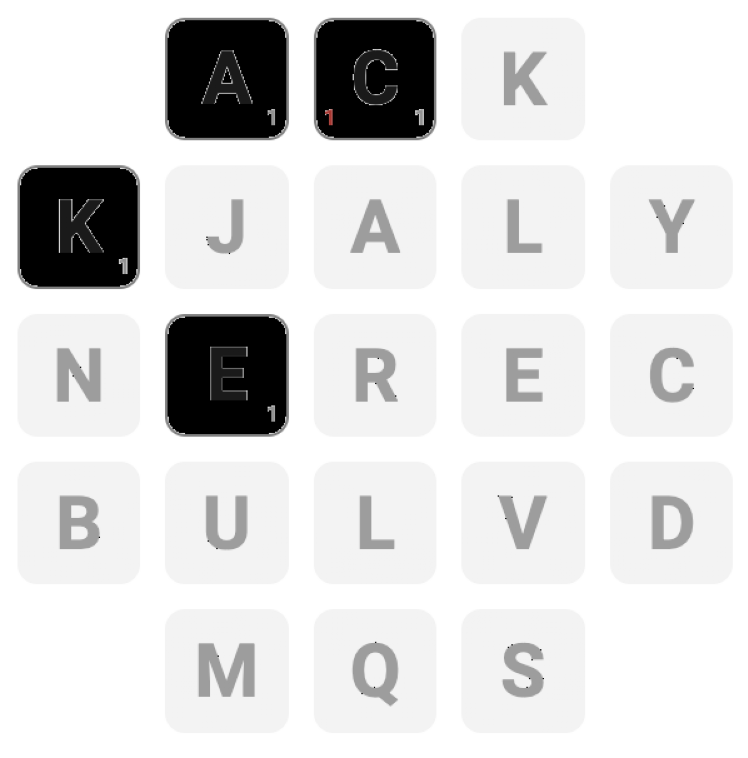

In [84]:
import cv2
import importlib
import cleanSquardle
importlib.reload(cleanSquardle)


img = cv2.imread("/Users/sagewong/git/SquardleBot/temp/screen.png", 1)
cropped_image = img[706:1297, 2233:2816]
og_img = cropped_image.copy()
rows, cols, _ = cropped_image.shape
for i in range(rows):
        for j in range(cols):
            if (cropped_image[i, j] == [224, 224, 224]).any():
                cropped_image[i, j] = [0, 0, 0]
cv2.imwrite("temp/cropped_image.png", cropped_image)
display("/Users/sagewong/git/SquardleBot/temp/cropped_image.png")

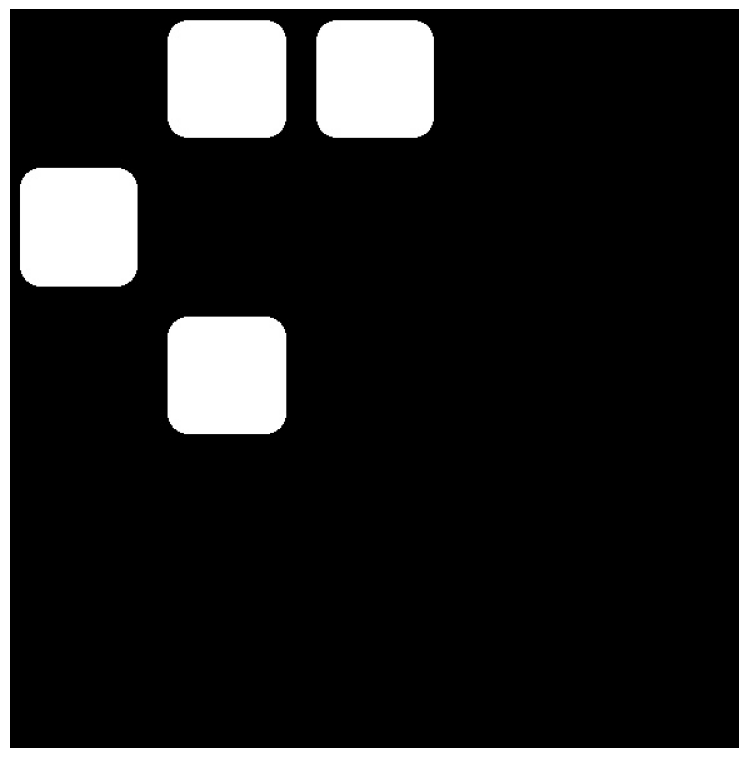

In [85]:
import numpy as np
kernel = np.ones((5, 5), np.uint8) 

blurred_image = cv2.erode(cropped_image, kernel)
inverse_image = cv2.bitwise_not(blurred_image)
thresh, threshed_img = cv2.threshold(inverse_image, 100, 255, cv2.THRESH_BINARY)
final_img = cv2.erode(threshed_img, kernel, iterations=2)


cv2.imwrite("temp/blurred_image.jpg", final_img)
display("temp/blurred_image.jpg")

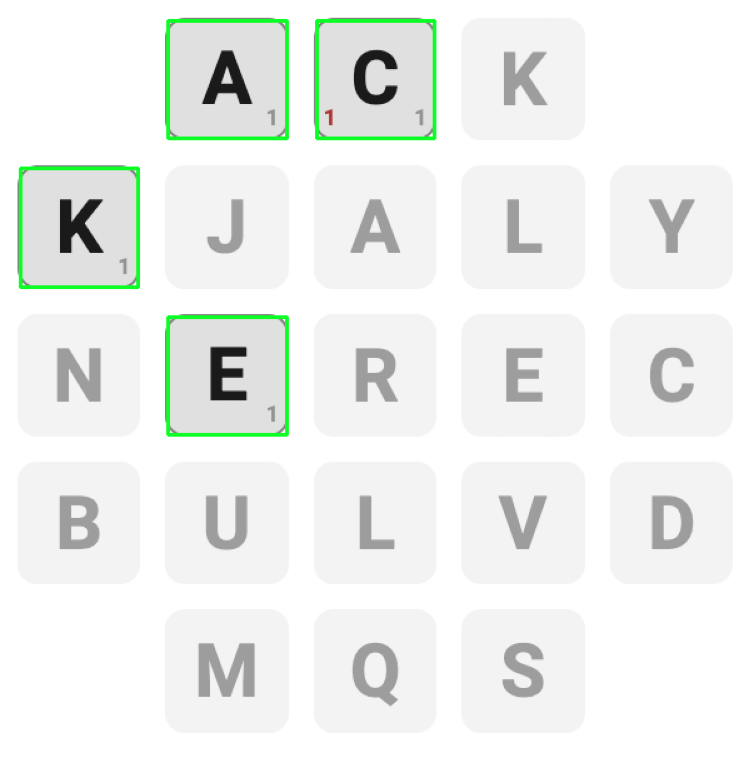

[['K\n', 8, 127], ['E\n', 126, 246], ['A\n', 126, 9], ['C\n', 245, 9]]


In [86]:
import pytesseract
converted_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
cv2.imwrite("temp/hi.png", converted_img)
cnts = cv2.findContours(converted_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
sortedList = []

cnts = sorted(cnts, key=lambda x: (cv2.boundingRect(x)[0]))
antiPadding = 20
wordList = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    roi = cv2.copyMakeBorder(og_img[y+antiPadding:y+h-antiPadding, x+antiPadding:x+w-antiPadding], 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[224, 224, 224])
    wordList.append([pytesseract.image_to_string(roi, config="--psm 10"), x, y])
    cv2.imwrite("temp/index_roi.png", roi)
    cv2.rectangle(og_img, (x, y), (x+w, y+h), (36, 255, 12), 2)
cv2.imwrite("temp/index_bbox_new.png", og_img)
display("temp/index_bbox_new.png")
print(wordList)

In [87]:
clusters = []
import fillEmptySpaces
importlib.reload(fillEmptySpaces)
from fillEmptySpaces import fillEmptySquares

wordList = fillEmptySquares(wordList)
for i in wordList:
    anyMatching = False
    for index, j in enumerate(clusters):
        if abs(j[0][0] - i[1]) < 10:
            clusters[index] = [[j[0][0]], j[1] + [i]]
            anyMatching = True
    if anyMatching == False:    
        clusters.append([[i[1]], [i]])
    if len(clusters) == 0:
        clusters.append([[i[1]], [i]])
print(clusters)

[[[8.0], [['-', 8.0, 9.0], ['K\n', 8, 127]]], [[127.0], [['-', 127.0, 128.0], ['E\n', 126, 246], ['A\n', 126, 9]]], [[245], [['C\n', 245, 9]]]]


In [91]:
newClusters = clusters.copy()
for index, i in enumerate(newClusters):
    newClusters[index][1] = sorted(newClusters[index][1], key=lambda x: x[2])
newClusters = sorted(newClusters, key=lambda x: x[0])
newClusters

[[[8.0], [['-', 8.0, 9.0], ['K\n', 8, 127]]],
 [[127.0], [['A\n', 126, 9], ['-', 127.0, 128.0], ['E\n', 126, 246]]],
 [[245], [['C\n', 245, 9]]]]

In [92]:
newNewClusters = []
for i in newClusters:
    newNewClusters.append(i[1])
newNewClusters

[[['-', 8.0, 9.0], ['K\n', 8, 127]],
 [['A\n', 126, 9], ['-', 127.0, 128.0], ['E\n', 126, 246]],
 [['C\n', 245, 9]]]

In [90]:
length = len(newNewClusters[0])
newestList = [[] for i in range(len(newNewClusters[0]))]
for j in range(length):
    for i in newNewClusters:
        newestList[j] = newestList[j] + [i[j][0].replace("\n", "").replace("|", "I").replace("0", "O").replace("@", "O"), i[j][1], i[j][2]]
newestList


IndexError: list index out of range